In [2]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import scipy
import scipy.signal as signal
import netCDF4 as nc
import plotly.express as ex



In [13]:
#load up data

gradients1_data = pd.read_csv("G1_Metab_Data.csv")
gradients1_metadata = pd.read_csv("G1_MetaData.csv")
peridice_data = pd.read_csv("PERIDICE_metabolite_data.csv")

In [4]:
print(gradients1_data.shape)
print(gradients1_data.columns)
print(peridice_data.columns)
print(gradients1_metadata.columns)

(84, 38)
Index(['Compound_name_in_figures', 'Complete_compound_name', 'S11C1_A',
       'S12C1_A', 'S12C1_B', 'S13C1_A', 'S13C1_B', 'S14C1_A', 'S14C1_B',
       'S14C1_C', 'S2C3_A', 'S4C1_A', 'S4C1_B', 'S4C1_C', 'S4C2_A', 'S4C2_B',
       'S6C1_A', 'S6C1_B', 'S6C1_C', 'S6C2_A', 'S6C2_B', 'S8C1_A', 'S9C1_A',
       'S9C1_B', 'S9C2_A', 'S9C2_B', 'U3_A', 'U3_B', 'U4_A', 'U4_B', 'U6_A',
       'U6_B', 'U7_A', 'U7_B', 'U8_A', 'U8_B', 'U9_A', 'U9_B'],
      dtype='object')
Index(['metabolite', 'treatment', 'date', 'triplicate', 'filename', 'nmol',
       'pc', 'pn', 'nmol_per_pc', 'added_N_uM'],
      dtype='object')
Index(['Sample_ID', 'Binned_latitude', 'Time_UTC', 'NO3_NO2', 'PO4', 'PC_nM',
       'PN_nM'],
      dtype='object')


**NMDS, PCA, Heatmap on Gradients 1 Data**
- PCR component analysis
- And heat map analysis of G1_metab_data.csv
    - Concentrations of metabolites in different areas
    - Do max normalizations on the values

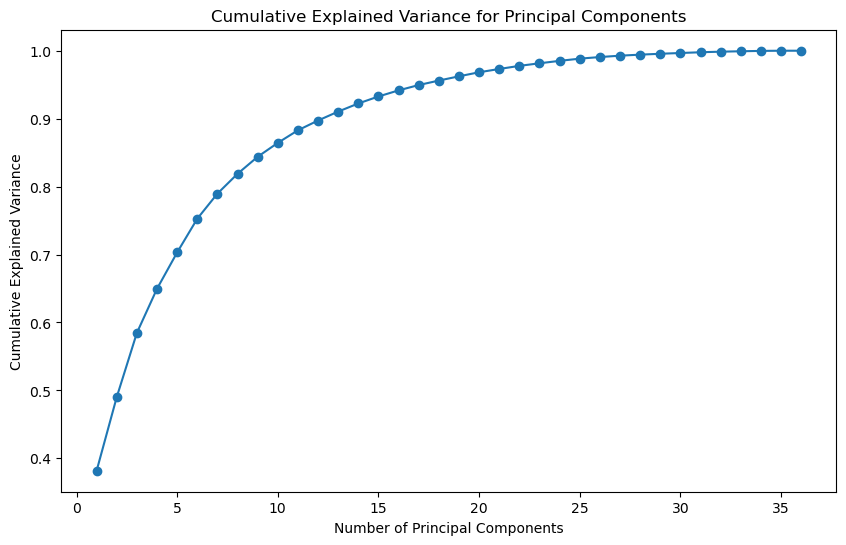

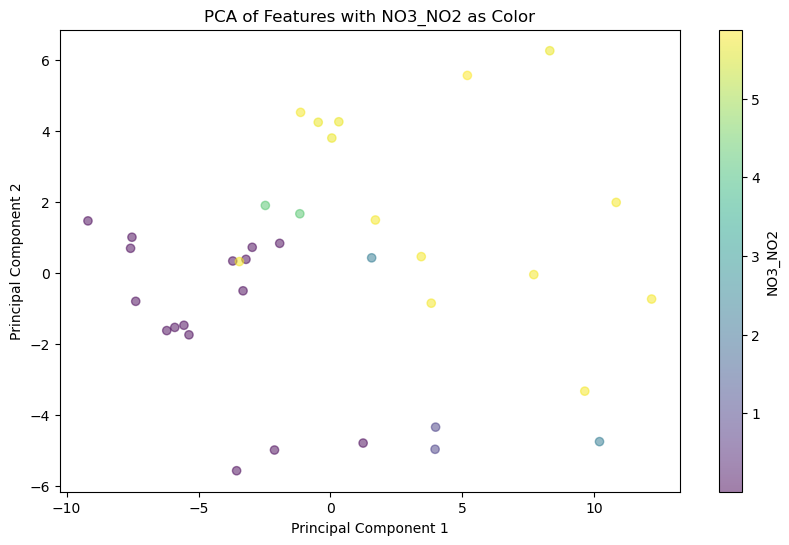

In [38]:
gradients1_data = gradients1_data.fillna(0)
gradients1_metadata = gradients1_metadata.fillna(0)

sample_ids = gradients1_data.columns[2:]

sample_ids_df = pd.DataFrame({'Sample_ID': sample_ids})

merged_data = pd.merge(sample_ids_df, gradients1_metadata, left_on='Sample_ID', right_on='Sample_ID', how='inner')
X = gradients1_data.set_index('Complete_compound_name').loc[:, sample_ids].T
y = merged_data[['NO3_NO2']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()

X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for Principal Components')
plt.show()

# Plot the first two principal components with color based on NO3_NO2
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],  c=y['NO3_NO2'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='NO3_NO2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Features with NO3_NO2 as Color')
plt.show()


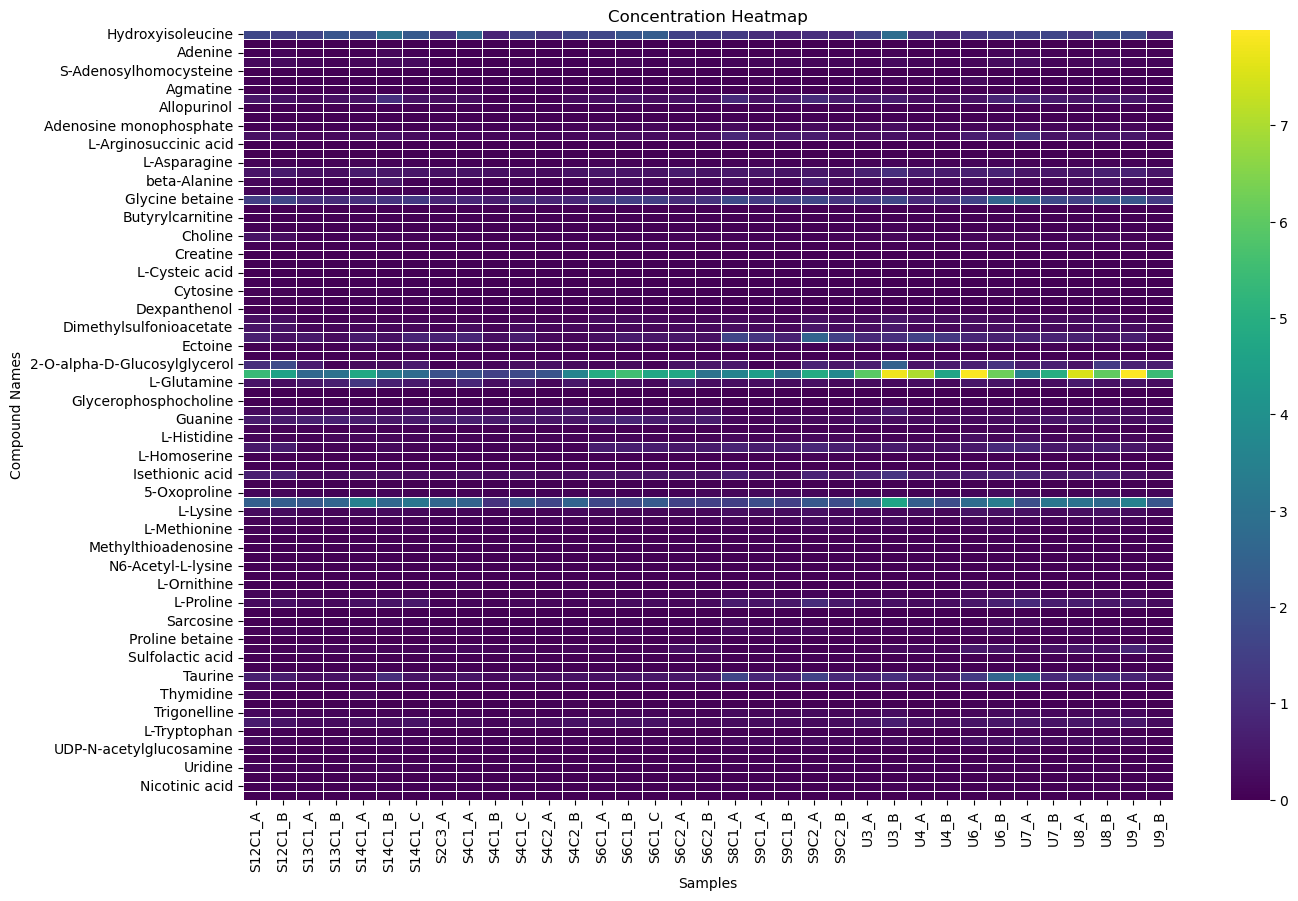

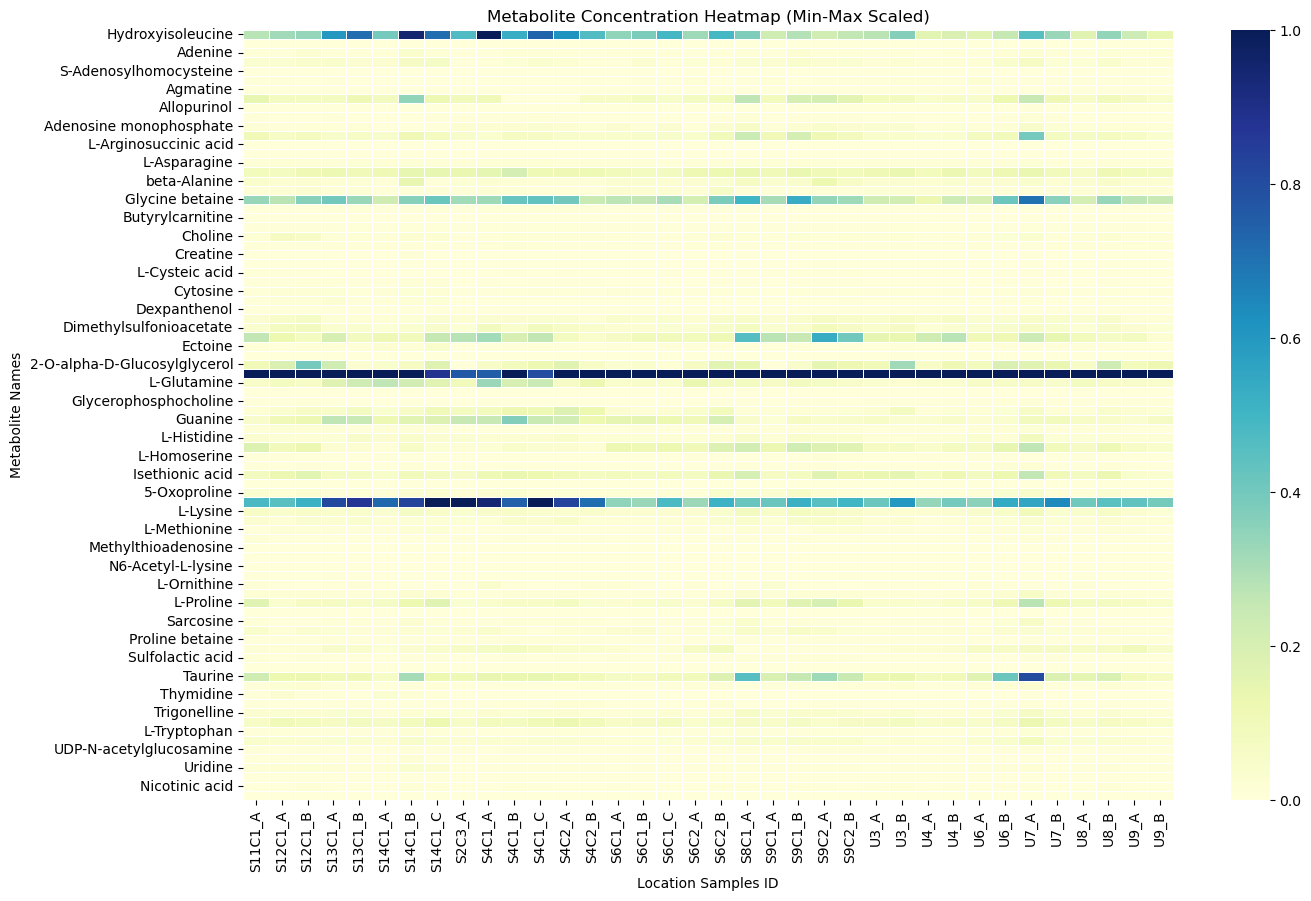

In [39]:
import seaborn as sns
gradients1_data = pd.read_csv("G1_Metab_Data.csv")

gradients1_data.set_index('Complete_compound_name', inplace=True)
gradients1_data.fillna(0, inplace=True)
# Create a heatmap
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
sns.heatmap(gradients1_data.iloc[:, 2:], cmap='viridis', fmt=".2f", linewidths=.5)

plt.title('Concentration Heatmap')
plt.xlabel('Samples')
plt.ylabel('Compound Names')
plt.show()


from sklearn.preprocessing import MinMaxScaler

# Load the data
gradients1_data = pd.read_csv("G1_Metab_Data.csv")
compound_names = gradients1_data['Complete_compound_name']


# Set the 'Complete_compound_name' column as the index
gradients1_data.set_index('Complete_compound_name', inplace=True)

# Fill NaN values with 0
gradients1_data.fillna(0, inplace=True)

# Use MinMaxScaler to scale values between 0 and 1
scaler = MinMaxScaler()
gradients1_data_scaled = pd.DataFrame(scaler.fit_transform(gradients1_data.iloc[:, 1:]), columns=gradients1_data.columns[1:])

# Reset the index to restore the 'Complete_compound_name'
gradients1_data_scaled['Complete_compound_name'] = compound_names
gradients1_data_scaled.set_index('Complete_compound_name', inplace=True)

# Create a heatmap with a more distinct color map
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
sns.heatmap(
    gradients1_data_scaled,
    cmap='YlGnBu',  # Yellow-Green-Blue color map
    annot=False,  # Turn off annotations to hide the numbers
    fmt=".2f",  # Format for annotations (optional)
    linewidths=.5
)

plt.title('Metabolite Concentration Heatmap (Min-Max Scaled)')
plt.xlabel('Location Samples ID')
plt.ylabel('Metabolite Names')
plt.show()

**Multiple Linear Regression**

Gradient 1 Train, Gradient 1 Test

Test Mean Squared Error NO3_NO2: 1.8966848202040814
Test R-squared NO3_NO2: 0.7353664533808113
Training Mean Squared Error NO3_NO2: 2.7080849399483483e-28
Training R-squared NO3_NO2: 1.0
                   Feature  Coefficient
0        Hydroxyisoleucine    -0.225262
1        O-Acetylcarnitine    -0.051793
2                  Adenine     0.026178
3                Adenosine     0.148370
4   S-Adenosylhomocysteine     0.054090
..                     ...          ...
79                  Uracil    -0.135005
80                 Uridine     0.013595
81              Riboflavin    -0.376269
82          Nicotinic acid     0.023608
83        Pantothenic acid     0.391903

[84 rows x 2 columns]


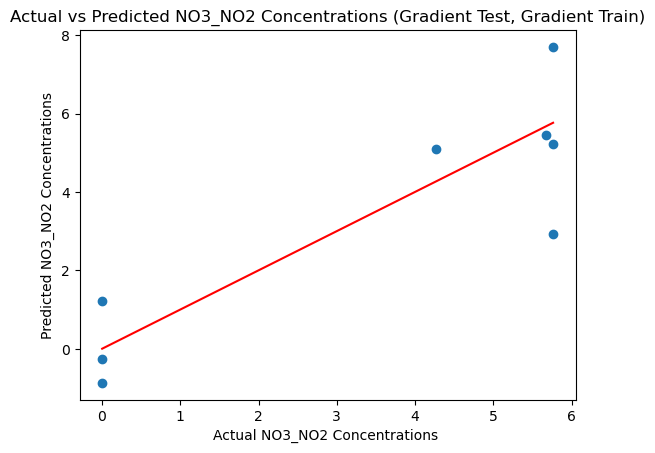

In [10]:
#selecting nutrients to predict
gradients1_data = gradients1_data.fillna(0)
gradients1_metadata = gradients1_metadata.fillna(0)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

sample_ids = gradients1_data.columns[2:]

sample_ids_df = pd.DataFrame({'Sample_ID': sample_ids})

merged_data = pd.merge(sample_ids_df, gradients1_metadata, left_on='Sample_ID', right_on='Sample_ID', how='inner')
X = gradients1_data.set_index('Complete_compound_name').loc[:, sample_ids].T
y = merged_data[['NO3_NO2']]

y_current = y['NO3_NO2']
X_train, X_test, y_train, y_test = train_test_split(X, y_current, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

predictions = model.predict(X_test_scaled)
train_predictions = model.predict(X_train_scaled)

mse = mean_squared_error(y_test, predictions)
print(f'Test Mean Squared Error NO3_NO2: {mse}')
r2 = r2_score(y_test, predictions)
print(f'Test R-squared NO3_NO2: {r2}')


train_mse = mean_squared_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
print(f'Training Mean Squared Error NO3_NO2: {train_mse}')
print(f'Training R-squared NO3_NO2: {train_r2}')
plt.scatter(y_test, predictions)

# Print the coefficients of the model
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients)

plt.xlabel(f'Actual NO3_NO2 Concentrations ')
plt.ylabel(f'Predicted NO3_NO2 Concentrations')
plt.title(f'Actual vs Predicted NO3_NO2 Concentrations (Gradient Test, Gradient Train)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

plt.show()

Peridice train, Peridice Test

Test Mean Squared Error NO3_NO2: 0.5972823322854501
Test R-squared NO3_NO2: 0.727562304362803
Training Mean Squared Error NO3_NO2: 0.6857527136965058
Training R-squared NO3_NO2: 0.7124920366415447
     Feature  Coefficient
0  nm_per_pc    -0.920640
1   n_per_pc    18.461519


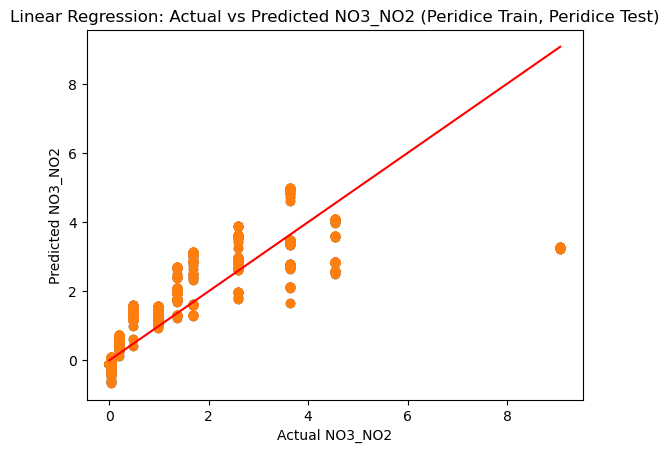

In [6]:
peridice_data = pd.read_csv("PERIDICE_metabolite_data.csv")

peridice_lr = peridice_data[['nmol', 'filename', 'metabolite', 'added_N_uM', 'pc', 'pn']].copy()
peridice_lr['nm_per_pc'] = peridice_lr['nmol'] / peridice_lr['pc']
peridice_lr['n_nmol'] = peridice_lr['added_N_uM'].fillna(0)
peridice_lr['n_per_pc'] = peridice_lr['n_nmol'] / peridice_lr['pc']
peridice_lr = peridice_lr.groupby(['metabolite', 'filename']).agg({
    'nmol': 'sum',
    'n_nmol': 'sum',
    'pc': 'first',
    'pn': 'first',
    'nm_per_pc': 'mean',
    'n_per_pc': 'mean'
}).reset_index()

peridice_lr = peridice_lr.fillna(0)

X = peridice_lr[['nm_per_pc', 'n_per_pc']]
y = peridice_lr['n_nmol'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
train_predictions = model.predict(X_train)

mse = mean_squared_error(y_test, predictions)
print(f'Test Mean Squared Error NO3_NO2: {mse}')
r2 = r2_score(y_test, predictions)
print(f'Test R-squared NO3_NO2: {r2}')


train_mse = mean_squared_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
print(f'Training Mean Squared Error NO3_NO2: {train_mse}')
print(f'Training R-squared NO3_NO2: {train_r2}')
plt.scatter(y_test, predictions)

# Print the coefficients of the model
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print(coefficients)

plt.scatter(y_test, predictions)
plt.xlabel('Actual NO3_NO2')
plt.ylabel('Predicted NO3_NO2')
plt.title('Linear Regression: Actual vs Predicted NO3_NO2 (Peridice Train, Peridice Test)')

# Add a 1-to-1 line (red)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

plt.show()

Peridice Train, Gradient Test

Test Mean Squared Error NO3_NO2: 14.66036565456861
Test R-squared NO3_NO2: -1.0510529827826987
Training Mean Squared Error NO3_NO2: 0.6678504151052738
Training R-squared NO3_NO2: 0.7153993288974406
     Feature  Coefficient
0  nm_per_pc    -0.073452
1   n_per_pc     1.295242


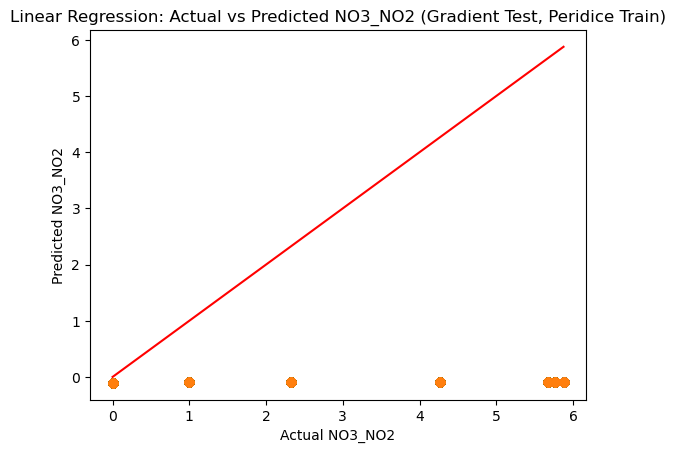

In [9]:
gradients1_data = pd.read_csv("G1_Metab_Data.csv")
gradients1_metadata = pd.read_csv("G1_MetaData.csv")
peridice_data = pd.read_csv("PERIDICE_metabolite_data.csv")

grad_lr = pd.merge(
    pd.melt(gradients1_data.drop('Compound_name_in_figures', axis=1), 
            id_vars=['Complete_compound_name'], 
            var_name='Sample_ID', 
            value_name='nmol'),
    gradients1_metadata,
    left_on='Sample_ID',
    right_on='Sample_ID'
)

grad_lr = grad_lr.rename(columns={'Complete_compound_name': 'metabolite', 'NO3_NO2': 'n_nmol', 'PC_nM': 'pc', 'PN_nM': 'pn'})
grad_lr['nm_per_pc'] = grad_lr['nmol'] / grad_lr['pc']
grad_lr['n_per_pc'] = grad_lr['n_nmol'] / grad_lr['pc']
#grad_lr = grad_lr[grad_lr['metabolite'].str.contains('Guanine|Arsenobetaine')]


peridice_lr = peridice_data[['nmol', 'filename', 'metabolite', 'added_N_uM', 'pc', 'pn']].copy()
peridice_lr['nm_per_pc'] = peridice_lr['nmol'] / peridice_lr['pc']
peridice_lr['n_nmol'] = peridice_lr['added_N_uM'].fillna(0)
peridice_lr['n_per_pc'] = peridice_lr['n_nmol'] / peridice_lr['pc']
#peridice_lr = peridice_lr[peridice_lr['metabolite'].str.contains('Guanine|Arsenobetaine')]

# Group by metabolite and filename
peridice_lr = peridice_lr.groupby(['metabolite', 'filename']).agg({
    'nmol': 'sum',
    'n_nmol': 'sum',
    'pc': 'first',
    'pn': 'first',
    'nm_per_pc': 'mean',
    'n_per_pc': 'mean'
}).reset_index()

peridice_lr = peridice_lr.fillna(0)
grad_lr = grad_lr.fillna(0)

X_train = peridice_lr[['nm_per_pc', 'n_per_pc']]
y_train = peridice_lr['n_nmol'] 

X_test = grad_lr[['nm_per_pc', 'n_per_pc']]
y_test = grad_lr['n_nmol'] 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()

model.fit(X_train_scaled, y_train)


predictions = model.predict(X_test_scaled)
train_predictions = model.predict(X_train_scaled)

mse = mean_squared_error(y_test, predictions)
print(f'Test Mean Squared Error NO3_NO2: {mse}')
r2 = r2_score(y_test, predictions)
print(f'Test R-squared NO3_NO2: {r2}')


train_mse = mean_squared_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
print(f'Training Mean Squared Error NO3_NO2: {train_mse}')
print(f'Training R-squared NO3_NO2: {train_r2}')
plt.scatter(y_test, predictions)

coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
print(coefficients)

plt.scatter(y_test, predictions)
plt.xlabel('Actual NO3_NO2')
plt.ylabel('Predicted NO3_NO2')
plt.title('Linear Regression: Actual vs Predicted NO3_NO2 (Gradient Test, Peridice Train)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

plt.show()

Test Mean Squared Error NO3_NO2: 244190.40038927892
Test R-squared NO3_NO2: -104059.3558158104
Training Mean Squared Error NO3_NO2: 0.016797005498133916
Training R-squared NO3_NO2: 0.9976500212177157
     Feature  Coefficient
0  nm_per_pc    -0.002077
1   n_per_pc     2.670289


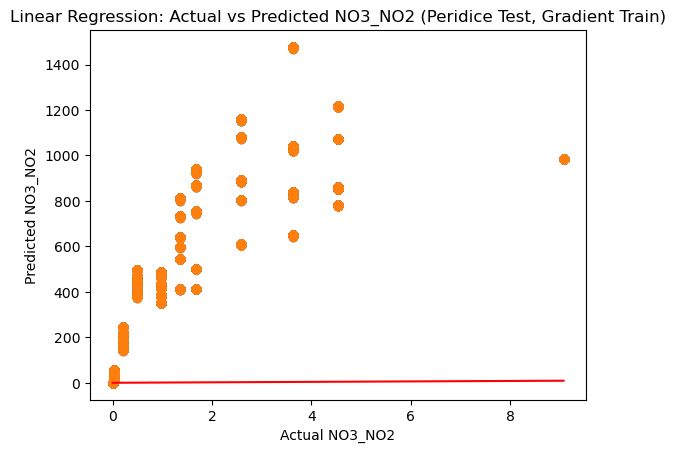

In [8]:
gradients1_data = pd.read_csv("G1_Metab_Data.csv")
gradients1_metadata = pd.read_csv("G1_MetaData.csv")
peridice_data = pd.read_csv("PERIDICE_metabolite_data.csv")

grad_lr = pd.merge(
    pd.melt(gradients1_data.drop('Compound_name_in_figures', axis=1), 
            id_vars=['Complete_compound_name'], 
            var_name='Sample_ID', 
            value_name='nmol'),
    gradients1_metadata,
    left_on='Sample_ID',
    right_on='Sample_ID'
)

grad_lr = grad_lr.rename(columns={'Complete_compound_name': 'metabolite', 'NO3_NO2': 'n_nmol', 'PC_nM': 'pc', 'PN_nM': 'pn'})
grad_lr['nm_per_pc'] = grad_lr['nmol'] / grad_lr['pc']
grad_lr['n_per_pc'] = grad_lr['n_nmol'] / grad_lr['pc']
#grad_lr = grad_lr[grad_lr['metabolite'].str.contains('Guanine|Arsenobetaine')]


peridice_lr = peridice_data[['nmol', 'filename', 'metabolite', 'added_N_uM', 'pc', 'pn']].copy()
peridice_lr['nm_per_pc'] = peridice_lr['nmol'] / peridice_lr['pc']
peridice_lr['n_nmol'] = peridice_lr['added_N_uM'].fillna(0)
peridice_lr['n_per_pc'] = peridice_lr['n_nmol'] / peridice_lr['pc']
#peridice_lr = peridice_lr[peridice_lr['metabolite'].str.contains('Guanine|Arsenobetaine')]

# Group by metabolite and filename
peridice_lr = peridice_lr.groupby(['metabolite', 'filename']).agg({
    'nmol': 'sum',
    'n_nmol': 'sum',
    'pc': 'first',
    'pn': 'first',
    'nm_per_pc': 'mean',
    'n_per_pc': 'mean'
}).reset_index()

peridice_lr = peridice_lr.fillna(0)
grad_lr = grad_lr.fillna(0)

X_train = grad_lr[['nm_per_pc', 'n_per_pc']]
y_train = grad_lr['n_nmol'] 

X_test = peridice_lr[['nm_per_pc', 'n_per_pc']]
y_test = peridice_lr['n_nmol'] 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_test_scaled)
train_predictions = model.predict(X_train_scaled)

mse = mean_squared_error(y_test, predictions)
print(f'Test Mean Squared Error NO3_NO2: {mse}')
r2 = r2_score(y_test, predictions)
print(f'Test R-squared NO3_NO2: {r2}')


train_mse = mean_squared_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
print(f'Training Mean Squared Error NO3_NO2: {train_mse}')
print(f'Training R-squared NO3_NO2: {train_r2}')
plt.scatter(y_test, predictions)
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
print(coefficients)

plt.scatter(y_test, predictions)
plt.xlabel('Actual NO3_NO2')
plt.ylabel('Predicted NO3_NO2')
plt.title('Linear Regression: Actual vs Predicted NO3_NO2 (Peridice Test, Gradient Train)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

plt.show()